# Telco Customer Churn Prediction

In this notebook, I use a number of conventional ML approaches to predict customer churn. The ieda is to use these as a benchmark for the DNN-based classifier. We will utilize the following classifiers:
 - Linear Logistic Regression
 - Decision Tree
 - Random Forest classifier 
 - Gradient

<br><br><br>
Load *Pandas*, *SciKit Learn*, *Numpy* and *MatplotLib*: 

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

<br><br><br>
# Load Data

The dataset can be obtained from either [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn) or [IBM](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113).

In [2]:
df = pd.read_csv("telco_customer_churn.csv")
display(df.sample(10))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1057,1624-WOIWJ,Female,0,No,No,10,Yes,No,Fiber optic,Yes,...,No,No,Yes,No,Month-to-month,Yes,Mailed check,84.70,832.05,Yes
1930,2792-VPPET,Male,0,No,No,3,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,20.50,76.95,No
2857,7771-CFQRQ,Female,0,Yes,Yes,47,Yes,No,DSL,No,...,No,Yes,No,Yes,Two year,No,Bank transfer (automatic),63.80,3007.25,No
6663,0674-EYYZV,Female,0,No,No,1,Yes,No,DSL,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,54.65,54.65,No
1064,3800-LYTRK,Female,0,No,No,14,Yes,No,DSL,Yes,...,No,Yes,No,No,One year,No,Mailed check,55.70,795.15,No
4408,2824-DXNKN,Female,0,Yes,Yes,72,Yes,Yes,DSL,Yes,...,Yes,No,Yes,No,Two year,Yes,Bank transfer (automatic),71.45,5025.85,No
1299,4566-QVRRW,Female,0,Yes,No,11,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,44.05,483.7,Yes
6471,0859-YGKFW,Male,0,Yes,Yes,18,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),20.05,345.9,No
5811,6754-LZUKA,Male,0,Yes,No,61,Yes,Yes,DSL,No,...,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),80.90,4932.5,No
6282,1354-YZFNB,Male,0,Yes,Yes,4,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.55,68.8,No


<br><br><br>
# Explore the Dataset

Let's explore the dataset and look for any conspecuous dependencies.

## Summary of Features and their Types

In [3]:
print(f"Num Rows: {len(df.index)}")

for col in df.columns:
    if df[col].dtype == np.object:
        print(f"\t{col:24}{str(df[col].dtype):16}{pd.unique(df[col])}")
    else:
        print(f"\t{col:24}{str(df[col].dtype):16}")

Num Rows: 7043
	customerID              object          ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
	gender                  object          ['Female' 'Male']
	SeniorCitizen           int64           
	Partner                 object          ['Yes' 'No']
	Dependents              object          ['No' 'Yes']
	tenure                  int64           
	PhoneService            object          ['No' 'Yes']
	MultipleLines           object          ['No phone service' 'No' 'Yes']
	InternetService         object          ['DSL' 'Fiber optic' 'No']
	OnlineSecurity          object          ['No' 'Yes' 'No internet service']
	OnlineBackup            object          ['Yes' 'No' 'No internet service']
	DeviceProtection        object          ['No' 'Yes' 'No internet service']
	TechSupport             object          ['No' 'Yes' 'No internet service']
	StreamingTV             object          ['No' 'Yes' 'No internet service']
	StreamingMovies         object  

### Does "TotalCharges" contain any useful/extra information? 

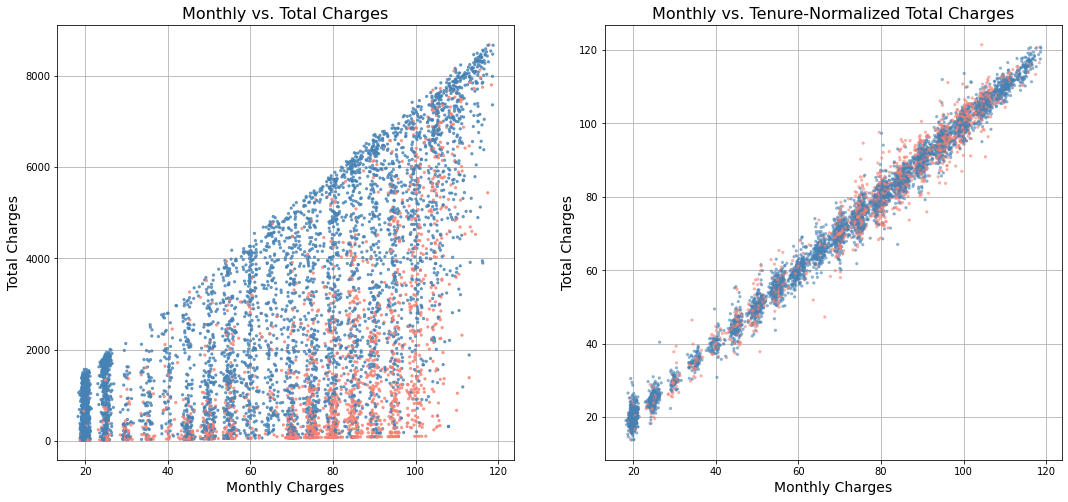

In [4]:
nan_total_charges = pd.to_numeric(df["TotalCharges"], errors="coerce").isnull().values
monthly_charges = df[~nan_total_charges]["MonthlyCharges"].values
tenure = df[~nan_total_charges]["tenure"].astype("float").values
total_charges = pd.to_numeric(df[~nan_total_charges]["TotalCharges"], errors="raise").values
churn = df[~nan_total_charges]["Churn"].apply(lambda x: True if x == "Yes" else False).values

fig = plt.figure(figsize=(18., 8.))
#
ax = plt.subplot(1, 2, 1)
ax.set_title("Monthly vs. Total Charges", fontsize=16)
ax.scatter(monthly_charges, total_charges,  
           marker="o", s=5.0, alpha=0.75, 
           c=np.where(churn, "salmon", "steelblue").tolist())
ax.set_xlabel("Monthly Charges", fontsize=14)
ax.set_ylabel("Total Charges", fontsize=14)
ax.grid()
ax.set_axisbelow(True)
#
ax = plt.subplot(1, 2, 2)
ax.set_title("Monthly vs. Tenure-Normalized Total Charges", fontsize=16)
ax.scatter(monthly_charges, total_charges / tenure, 
           marker="o", s=5.0, alpha=0.5, 
           c=np.where(churn, "salmon", "steelblue").tolist())
ax.set_xlabel("Monthly Charges", fontsize=14)
ax.set_ylabel("Total Charges", fontsize=14)
ax.grid()
ax.set_axisbelow(True)
#
plt.show()

### How Correlated are the Internet-Related Features?

These are:
 - InternetService {'DSL' 'Fiber optic' 'No'}
 - OnlineSecurity {'No' 'Yes' 'No internet service'}
 - OnlineBackup {'Yes' 'No' 'No internet service'}
 - DeviceProtection {'No' 'Yes' 'No internet service'}
 - TechSupport {'No' 'Yes' 'No internet service'}
 - StreamingTV {'No' 'Yes' 'No internet service'}
 - StreamingMovies {'No' 'Yes' 'No internet service'}

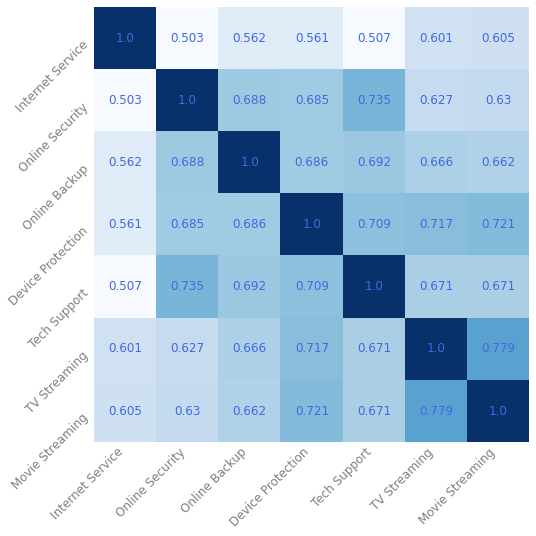

In [5]:
internet_related_features = {}
internet_related_features["Internet Service"] = df["InternetService"].apply(
    lambda x: False if x == "No" else True).values
internet_related_features["Online Security"] = df["OnlineSecurity"].apply(
    lambda x: True if x == "Yes" else False).values
internet_related_features["Online Backup"] = df["OnlineBackup"].apply(
    lambda x: True if x == "Yes" else False).values
internet_related_features["Device Protection"] = df["DeviceProtection"].apply(
    lambda x: True if x == "Yes" else False).values
internet_related_features["Tech Support"] = df["TechSupport"].apply(
    lambda x: True if x == "Yes" else False).values
internet_related_features["TV Streaming"] = df["StreamingTV"].apply(
    lambda x: True if x == "Yes" else False).values
internet_related_features["Movie Streaming"] = df["StreamingMovies"].apply(
    lambda x: True if x == "Yes" else False).values

correlation_matrix = np.eye(
    len(internet_related_features), 
    dtype=np.single)
for row_idx, row_feature_name in enumerate(internet_related_features.keys()):
    correlation_matrix[row_idx, row_idx] = 1.0
    for col_idx, col_feature_name in enumerate(internet_related_features.keys()):
        if col_feature_name == row_feature_name:
            break
        else:
            correlation_matrix[row_idx, col_idx] = np.sum(
                np.logical_not(np.logical_xor(
                    internet_related_features[row_feature_name],
                    internet_related_features[col_feature_name])
            )).astype(np.single) / len(df.index)
            correlation_matrix[col_idx, row_idx] = correlation_matrix[row_idx, col_idx]
            
fig = plt.figure(figsize=(8., 8.))
ax = plt.gca()
ax.imshow(correlation_matrix, cmap="Blues")
ax.set_xticks(range(len(internet_related_features)))
ax.set_xticklabels(list(internet_related_features.keys()), 
                   rotation=45, ha="right", va="top", 
                   fontsize=12, fontweight="normal", color="gray")
ax.set_yticks(range(len(internet_related_features)))
ax.set_yticklabels(list(internet_related_features.keys()), 
                   rotation=45, ha="right", va="top", 
                   fontsize=12, fontweight="normal", color="gray")
for row_idx in range(correlation_matrix.shape[0]):
    for col_idx in range(correlation_matrix.shape[1]):
        ax.text(row_idx, col_idx, str(round(float(correlation_matrix[row_idx, col_idx]), 3)), 
                ha="center", va="center", color="royalblue", 
                fontsize=12, fontweight="normal", transform=ax.transData)
for name in ax.spines.keys():
    ax.spines[name].set_visible(False)
ax.tick_params(axis="both", which="both",length=0)
plt.show()

## Visual Inspection of Dependence on Various Features:

In [6]:
churn = df["Churn"].apply(lambda x: True if x == "Yes" else False).values
print(f"Customor Churn: {np.sum(churn)} / {np.prod(churn.shape)} = {np.round(np.sum(churn)/np.prod(churn.shape), 2)}")

Customor Churn: 1869 / 7043 = 0.27


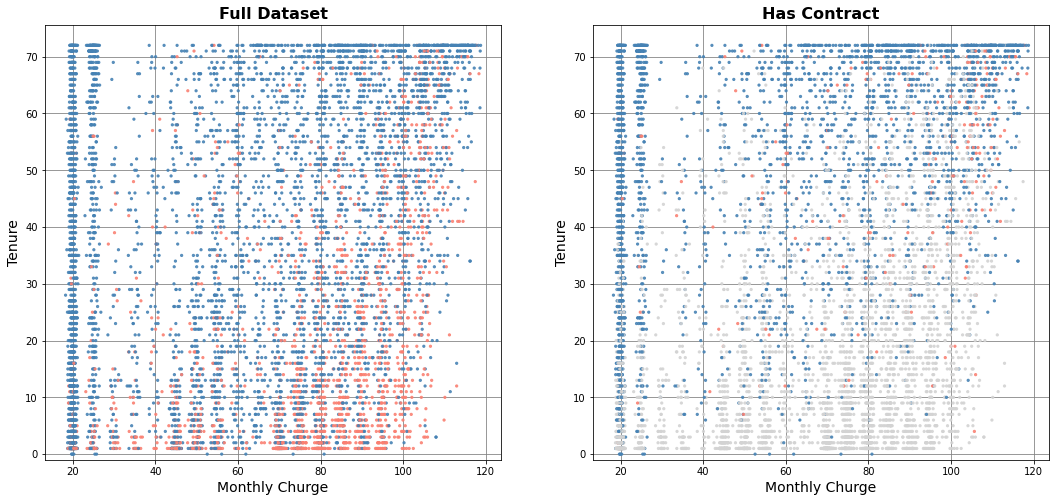

In [7]:
churn = df["Churn"].apply(lambda x: True if x == "Yes" else False).values
monthly_charges = df["MonthlyCharges"].values.astype(np.single)
tenure = df["tenure"].values.astype(np.single)
contract = df["Contract"].apply(
    lambda x: False if x == "Month-to-month" else True).values


fig = plt.figure(figsize=(18., 8.))
#
ax = plt.subplot(1, 2, 1)
ax.set_title("Full Dataset", fontsize=16, fontweight="bold")
ax.set_xlabel("Monthly Churge", fontsize=14.)
ax.set_ylabel("Tenure", fontsize=14.)
ax.scatter(
    monthly_charges, tenure,
    marker="o", s=5.0, alpha=0.85,
    c=np.where(churn, "salmon", "steelblue").tolist())
ax.set_ylim(-1,)
ax.grid(color="gray")
ax.set_axisbelow(True)
#
ax = plt.subplot(1, 2, 2)
ax.set_title("Has Contract", fontsize=16, fontweight="bold")
ax.set_xlabel("Monthly Churge", fontsize=14.)
ax.set_ylabel("Tenure", fontsize=14.)
ax.scatter(
    monthly_charges, tenure,
    marker="o", s=5.0, alpha=0.85, 
    c=np.where(contract, np.where(churn, "salmon", "steelblue"), "lightgray").tolist())
ax.set_ylim(-1,)
ax.grid(color="gray")
ax.set_axisbelow(True)
#
plt.show()

### How Correlated "Contract" and "Churn" are?

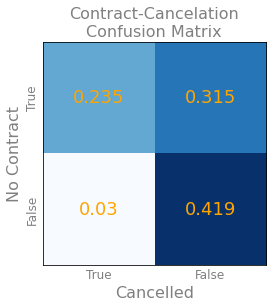

In [8]:
correlation_matrix = np.eye(2, dtype=np.single)
correlation_matrix[0, 0] = np.sum(np.logical_and(
    np.logical_not(contract), 
    churn))
correlation_matrix[0, 1] = np.sum(np.logical_and(
    np.logical_not(contract), 
    np.logical_not(churn)))
correlation_matrix[1, 0] = np.sum(np.logical_and(
    contract, 
    churn))
correlation_matrix[1, 1] = np.sum(np.logical_and(
    contract, 
    np.logical_not(churn)))
correlation_matrix /= np.sum(correlation_matrix)


fig = plt.figure(figsize=(4., 4.5))
ax = plt.gca()
ax.set_title("Contract-Cancelation\nConfusion Matrix", fontsize=16., color="gray")
ax.imshow(correlation_matrix, cmap="Blues")
ax.set_xlabel("Cancelled", fontsize=16, fontweight="normal", color="gray")
ax.set_xticks([0, 1])
ax.set_xticklabels(
    ["True", "False"], rotation=0, ha="center", va="top", 
    fontsize=12, fontweight="normal", color="gray")
ax.set_ylabel("No Contract", fontsize=16, fontweight="normal", color="gray")
ax.set_yticks([0, 1])
ax.set_yticklabels(
    ["True", "False"], rotation=90, ha="right", va="center", 
    fontsize=12, fontweight="normal", color="gray")
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(round(float(correlation_matrix[i, j]), 3)), 
                ha="center", va="center", color="orange", 
                fontsize=18, fontweight="normal", transform=ax.transData)
for name in ax.spines.keys():
    ax.spines[name].set_visible(True) #False)
ax.tick_params(axis="both", which="both",length=0)
plt.show()

## Summary of Analyzing Features:

 - "Contract" is a strong predictor of customer churn!
 - "TotalCharges" does not seem to contain any new infromation.
 - "StreamingTV" and "StreamingMovies" seem to be fairly correlated.
 - "OnlineSecurity" and "TechSupport" are also pretty correlated.

<br><br><br>
# Linear Logstic Regression

<br><br><br>

# Decision Tree Classfier

<br><br><br>
# Random Forest Classfier

<br><br><br>
# Gradient Bosting Classifier